In [ ]:
!pip install transformers
!pip install -q --upgrade ipython
!pip install -q --upgrade ipykernel

In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import BertConfig,AdamW,BertForSequenceClassification,get_linear_schedule_with_warmup

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import logging
import random 
from tqdm import tqdm, trange,tnrange,tqdm_notebook
from torch.optim import AdamW

from torch.autograd import Variable
logging.basicConfig(level=logging.ERROR)
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

SEED = 19

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception (pywin32 224 (c:\anaconda\lib\site-packages), Requirement.parse('pywin32==227; sys_platform == "win32"'), {'docker'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (pywin32 224 (c:\anaconda\lib\site-packages), Requirement.parse('pywin32==227; sys_platform == "win32"'), {'docker'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.PipelineRun = azureml.pipeline.core.run:PipelineRun._from_dto with exception (pywin32 224 (c:\anaconda\lib\site-packages), Requirement.parse('pywin32==227; sys_platform == "win32"'), {'docker'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.ReusedStepRun = azureml.pipeline.core.run:StepRun._from_reused_dto with exception (pywin32 2

# Data Preprocessing 

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


Only label dataset was used, the title and abstract of the articles were joined . there are 17 classes of reasearch methods and 100 data points articles avalable in the dataset

In [ ]:
label=pd.read_json('/content/drive/MyDrive/lonformer/LABEL')
paper=pd.read_json('/content/drive/MyDrive/lonformer/PAPER.json', orient=str)
cite=pd.read_json('/content/drive/MyDrive/lonformer/CITE.json', orient=str)
label.head()

,Unnamed: 0,outlet,journal_name,journal_akronym,year,authors,title,vol,issue,pages,abstract,research_methods,filename
1606,1606,Conference,Proceedings of the International Conference on...,ICIS,2005,"Rajiv D. Banker, Sabyasachi Mitra",Impact of Information Technology on Agricultur...,NaN,NaN,None,Empirical research on the value of information...,"Data Analytics, Conceptual, Field Study",BankerR#MitraS_2005_Impact of Information Tech...
1270,1270,Conference,Proceedings of the International Conference on...,ICIS,2015,"Oliver Francis Koch, Alexander Benlian",Designing Viral Promotional Campaigns: How Sca...,NaN,NaN,None,Online referrals have become an important mech...,"Field Experiment, Conceptual, Survey",KochO#BenlianA_2015_Designing Viral Promotiona...
1367,1367,Conference,Proceedings of the International Conference on...,ICIS,2015,"Junyeong Lee, Jinyoung Min, Heeseok Lee",Setting a Knowledge Boundary for Enhancing Wor...,NaN,NaN,None,Since teams are built around specialized and d...,Survey,LeeJ#MinJ#LeeH_2015_Setting a Knowledge Bounda...
671,671,Journal,Information Systems Research,ISR,2015,"Frago Kourandi, Jan Krämer, Tommaso Valletti","Net Neutrality, Exclusivity Contracts, and Int...",26.0,2.0,320-338,Net neutrality (NN) is believed to prevent the...,Conceptual,KourandiF#KrämerJ#VallettiT_2015_Net Neutralit...
1212,1212,Conference,Proceedings of the International Conference on...,ICIS,1995,Daniel Robey,Theories that Explain Contradiction: Accountin...,NaN,NaN,None,The potential of information technology to tra...,"Literature Review, Opinion",RobeyD_1995_Theories that Explain Contradictio...


In [ ]:
cite_paper=pd.merge(cite,paper,on='article_id')
cite_paper_label=pd.merge(cite_paper,label,on='title')

In [ ]:
dataset=cite_paper_label[['article_id','title', 'abstract_x', 'research_methods','sentence_with_cite']]
dataset_2=cite_paper_label[['article_id','title', 'abstract_x', 'research_methods']].drop_duplicates(subset=['article_id'])



In [ ]:
df=pd.DataFrame(dataset.groupby('article_id')['sentence_with_cite'].apply(
               lambda x: pd.Series(' '.join(x) )
            ))
dataset_2=pd.merge(dataset_2,df.reset_index().drop('level_1',1),on='article_id')

In [ ]:
dataset_2['TEXT']=dataset_2['title']+dataset_2['abstract_x']+dataset_2['sentence_with_cite']
dataset=dataset_2[['article_id','TEXT','research_methods']]

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
df = pd.DataFrame(mlb.fit_transform(dataset['research_methods'].str.split(', ')))
df.columns=mlb.classes_
dataset=pd.concat([dataset,df],axis=1)

dataset.head()

,article_id,TEXT,research_methods,Case Study,Conceptual,Data Analytics,Ethnography,Field Study,Literature Review,Opinion,Other,Survey
0,55,Information flows amongst executives: their im...,"Conceptual, Case Study",1,1,0,0,0,0,0,0,0
1,893,Impact of Information Technology on Agricultur...,"Data Analytics, Conceptual, Field Study",0,1,1,0,1,0,0,0,0
2,953,Predictive Analytics for Readmission of Patien...,"Conceptual, Field Study",0,1,0,0,1,0,0,0,0
3,2516,Avoiding methodological overdose: a declaratio...,Opinion,0,0,0,0,0,0,1,0,0
4,2869,"New games, new rules: big data and the changin...",Other,0,0,0,0,0,0,0,1,0


In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
import re
# Setup stopwords list & word (noun, adjective, and verb) lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    """Function to clean text using RegEx operations, removal of stopwords, and lemmatization."""
    text = re.sub(r'[^\w\s]', '', text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(' ')]
    text = [lemmatizer.lemmatize(token, 'v') for token in text]
    text = [word for word in text if word not in stop_words]
    text = ' '.join(text)
    text = text.lstrip().rstrip()
    text = re.sub(' +', ' ', text)
    return text




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
dataset['LABEL']=dataset.iloc[:,3:].values.tolist()

dataset.TEXT=dataset.TEXT.apply(clean_text)
dataset_2=dataset[['article_id','TEXT','LABEL']]
dataset_2.head()

,article_id,TEXT,LABEL
0,55,information flow amongst executive implication...,"[1, 1, 0, 0, 0, 0, 0, 0, 0]"
1,893,impact information technology agricultural com...,"[0, 1, 1, 0, 1, 0, 0, 0, 0]"
2,953,predictive analytics readmission patient conge...,"[0, 1, 0, 0, 1, 0, 0, 0, 0]"
3,2516,avoid methodological overdose declaration inde...,"[0, 0, 0, 0, 0, 0, 1, 0, 0]"
4,2869,new game new rule big data change context stra...,"[0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(dataset_2, test_size=0.2, random_state=35)
val, test = train_test_split(val, test_size=0.5, random_state=RANDOM_SEED,shuffle=False)
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape,test.shape)
train.head()

Training Set Shape : (25, 3)
Validation Set Shape : (3, 3) (4, 3)


,article_id,TEXT,LABEL
0,10814,develop integration architecture process porta...,"[1, 1, 0, 0, 0, 0, 0, 0, 0]"
1,8475,empirical study information technology outsour...,"[0, 0, 0, 0, 1, 0, 0, 0, 1]"
2,6825,editorial note write editorial first issue set...,"[0, 0, 0, 0, 0, 0, 0, 1, 0]"
3,11591,assess quality institutional ds effectively as...,"[1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,8926,make largescale information resource serve com...,"[0, 0, 0, 0, 0, 0, 1, 0, 0]"


In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, truncation=True, do_lower_case=True)
MAX_LEN=512
num_labels=dataset_2['LABEL'].apply(len).max()

In [ ]:
positive_counts=[]
from collections import Counter
for col in dataset.columns[3:-1]:
  positive_counts.append(dict(Counter(dataset[col]))[1])


def calculate_pos_weights(class_counts,data):
    pos_weights = np.ones_like(class_counts)
    neg_counts = [len(data)-pos_count for pos_count in class_counts]
    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts,  neg_counts)):
        pos_weights[cdx] = neg_count / (pos_count + 1e-5)

    return torch.as_tensor(pos_weights, dtype=torch.float)


pos_weight=calculate_pos_weights(positive_counts,dataset)
pos_weight

tensor([ 5.,  1., 14., 30.,  2., 30.,  6.,  2.,  2.])

In [ ]:
##Number of tokens in each article , is plotted in a distribution plot

Token indices sequence length is longer than the specified maximum sequence length for this model (8640 > 512). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


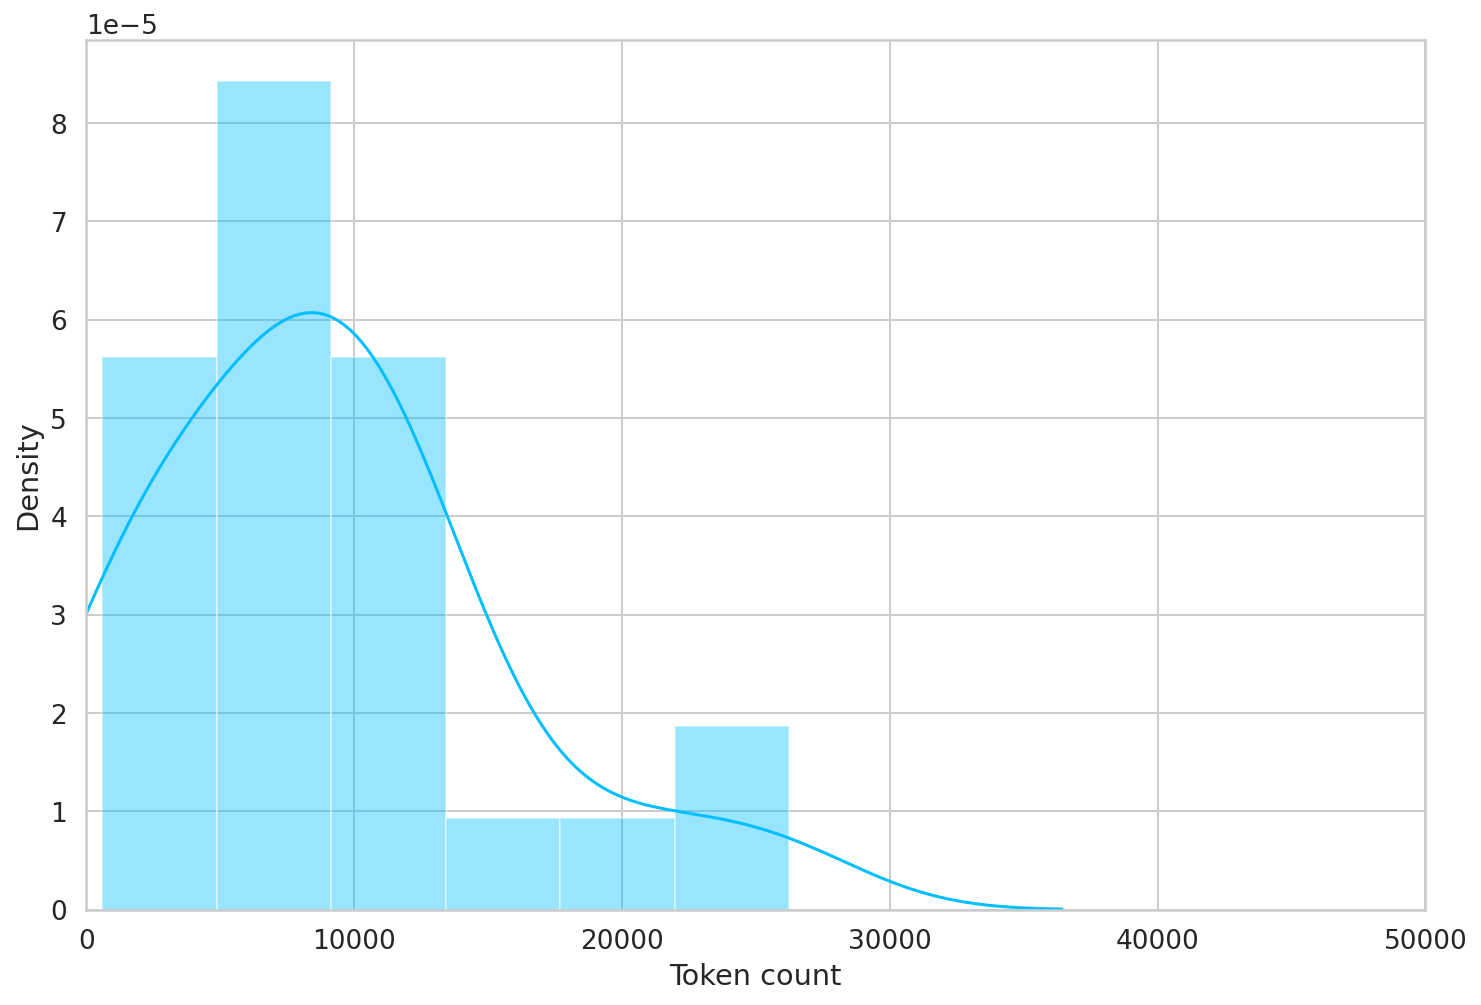

In [ ]:
token_lens = []

for txt in train.TEXT:
    tokens = tokenizer.encode(txt)
    token_lens.append(len(tokens))
    
sns.distplot(token_lens)
plt.xlim([0, 50000]);
plt.xlabel('Token count');

The sentences where split at 100 words and a overlapping window of 150 words was taken between subsequent split sentences. This overlap helps in connecting between the split sentences

In [ ]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//100 >0:
    n = len(text1.split())//100
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:150]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*100:w*100 + 150]
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
train_2=train.copy()

train['text_split'] = train['TEXT'].apply(get_split)
train=train.set_index(['article_id'])['text_split'].apply(
               lambda x: pd.Series([' '.join(x[i:i+1]) for i in range(0, len(x), 1)])
            ).stack().reset_index().drop('level_1',1).rename(columns={0:'TEXT'})
train=pd.merge(train,train_2[['article_id','LABEL']],on='article_id')
train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,article_id,TEXT,LABEL
0,10814,develop integration architecture process porta...,"[1, 1, 0, 0, 0, 0, 0, 0, 0]"
1,10814,literature practice adequately address interor...,"[1, 1, 0, 0, 0, 0, 0, 0, 0]"
2,10814,"architecture (menasce & almeida, 2000) j j e-e...","[1, 1, 0, 0, 0, 0, 0, 0, 0]"
3,10814,"j j ovum enterprise portal (ovum, 2000) j j j ...","[1, 1, 0, 0, 0, 0, 0, 0, 0]"
4,10814,second business intelligencewhen link data war...,"[1, 1, 0, 0, 0, 0, 0, 0, 0]"


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


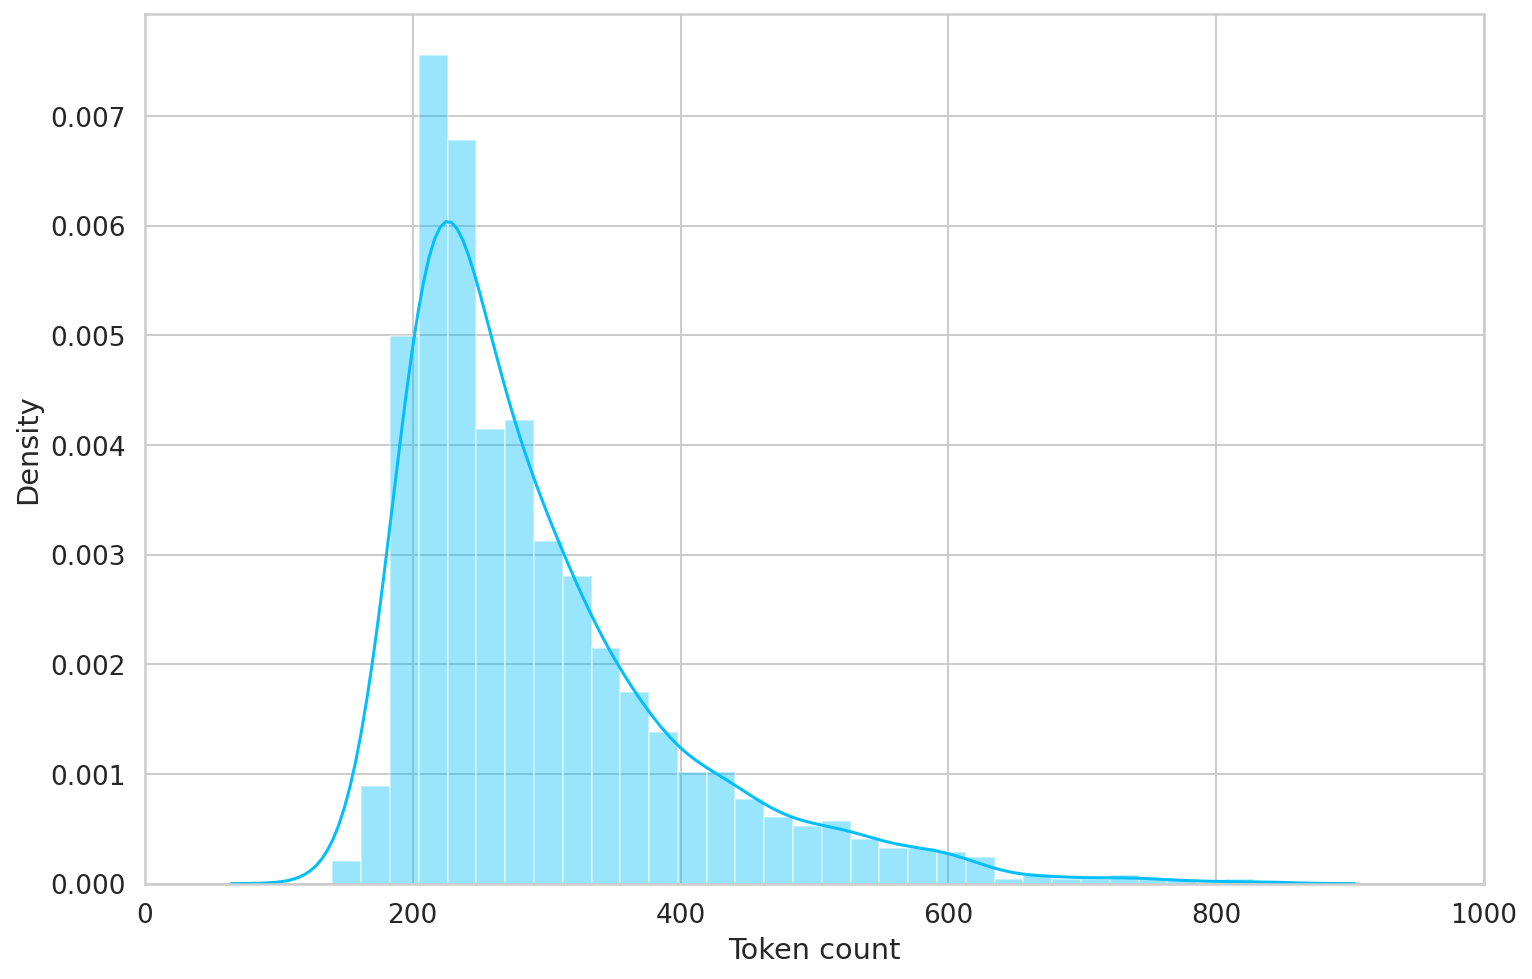

In [ ]:
token_lens = []

for txt in train.TEXT:
    tokens = tokenizer.encode(txt)
    token_lens.append(len(tokens))
    
sns.distplot(token_lens)
plt.xlim([0,1000]);
plt.xlabel('Token count');

In [ ]:
val_2=val.copy()

val['text_split'] = val['TEXT'].apply(get_split)
val=val.set_index(['article_id'])['text_split'].apply(
               lambda x: pd.Series([' '.join(x[i:i+1]) for i in range(0, len(x), 1)])
            ).stack().reset_index().drop('level_1',1).rename(columns={0:'TEXT'})

val=pd.merge(val,val_2[['article_id','LABEL']],on='article_id')

val.head(2)

,article_id,TEXT,LABEL
0,8747,towards enhancement edemocracy identify notion...,"[1, 1, 0, 0, 0, 0, 0, 0, 0]"
1,8747,add new dimension exist theory hesitant evolut...,"[1, 1, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
test_2=test.copy()
test['text_split'] = test['TEXT'].apply(get_split)
test=test.set_index(['article_id'])['text_split'].apply(
               lambda x: pd.Series([' '.join(x[i:i+1]) for i in range(0, len(x), 1)])
            ).stack().reset_index().drop('level_1',1).rename(columns={0:'TEXT'})


test=pd.merge(test,test_2[['article_id','LABEL']],on='article_id')


test.head(2)

,article_id,TEXT,LABEL
0,11547,editorial note performance journal 2006 review...,"[0, 0, 0, 0, 0, 0, 0, 1, 0]"
1,11547,last year number revision ha go significantly ...,"[0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [ ]:
class Dataset(Dataset):

  def __init__(self, article,reviews, targets, tokenizer, max_len):
    self.article=article
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    review = " ".join(review.split())
    article=self.article[item]
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True,
      return_attention_mask=True,
    return_token_type_ids=True,
    truncation=True
    )

    return {'article_id':article,
      'review_text': review,
      'input_ids':  torch.tensor(encoding['input_ids'], dtype=torch.long),
      'attention_mask':  torch.tensor(encoding['attention_mask'], dtype=torch.long),
        'token_type_ids': torch.tensor(encoding["token_type_ids"], dtype=torch.long),
      'targets': torch.tensor(target, dtype=torch.float)
    }

In [ ]:
train.shape, val.shape, test.shape

((1145, 3), (169, 3), (178, 3))

In [ ]:
train

,article_id,TEXT,LABEL
0,10814,develop integration architecture process porta...,"[1, 1, 0, 0, 0, 0, 0, 0, 0]"
1,10814,literature practice adequately address interor...,"[1, 1, 0, 0, 0, 0, 0, 0, 0]"
2,10814,"architecture (menasce & almeida, 2000) j j e-e...","[1, 1, 0, 0, 0, 0, 0, 0, 0]"
3,10814,"j j ovum enterprise portal (ovum, 2000) j j j ...","[1, 1, 0, 0, 0, 0, 0, 0, 0]"
4,10814,second business intelligencewhen link data war...,"[1, 1, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...
1140,8465,update intellectual property regime ''maximize...,"[0, 0, 0, 0, 0, 0, 1, 0, 0]"
1141,11544,editorial note synergistic relationship inform...,"[0, 0, 0, 0, 0, 0, 0, 1, 0]"
1142,11544,system society inform society community provid...,"[0, 0, 0, 0, 0, 0, 0, 1, 0]"
1143,11544,"pages. second, isr also commit publish annual ...","[0, 0, 0, 0, 0, 0, 0, 1, 0]"


In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Dataset(
    article=df.article_id.to_numpy(),
    reviews=df.TEXT.to_numpy(),
    targets=df.LABEL.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0,
  )

In [ ]:
BATCH_SIZE = 1
MAX_LEN=512
train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
class FineTunedBert(nn.Module):
    """
    Finetuning model that utilizes BERT tokenizer, pretrained BERT embedding, pretrained BERT
    encoders, an optional recurrent neural network  choice of LSTM, dropout, and finally a dense
    layer for classification.
    @param (str) pretrained_model_name: name of the pretrained BERT model for tokenizing input
           sequences, extracting vector representations for each token, [...]
    @param (int) num_pretrained_bert_layers: number of BERT Encoder layers to be utilized
    @param (int) max_tokenization_length: maximum number of positional embeddings, or the sequence
           length of an example that will be fed to BERT model (default: 512)
    @param (int) num_classes: number of classes to distinct between for classification; specify
           2 for binary classification (default: 1)
    @param (bool) top_down: whether to assign parameters (weights and biases) in order or
           backwards (default: True)
    @param (int) num_recurrent_layers: number of LSTM layers to utilize (default: 1)
    @param (bool) use_bidirectional: whether to use a bidirectional LSTM or not (default: False)
    @param (int) hidden_size: number of recurrent units in each LSTM cell (default: 128)
    @param (bool) reinitialize_pooler_parameters: whether to use the pretrained pooler parameters
           or initialize weights as ones and biases zeros and train for scratch (default: False)
    @param (float) dropout_rate: possibility of each neuron to be discarded (default: 0.10)
    @param (bool) aggregate_on_cls_token: whether to pool on only the hidden states of the [CLS]
           token for classification or on the hidden states of all (512) tokens (default: True)
    @param (bool) concatenate_hidden_states: whether to concatenate all the available hidden states
           outputted by the embedding and encoder layers (K+1) or only use the latest hidden state
           (default: False)
    @param (bool) use_gpu: whether to utilize GPU (CUDA) or not (default: False)
    """
    def __init__(self, pretrained_model_name, num_pretrained_bert_layers, max_tokenization_length,
                 num_classes=1, top_down=True, num_recurrent_layers=1, use_bidirectional=False,
                 hidden_size=128, reinitialize_pooler_parameters=False, dropout_rate=0.10,
                 aggregate_on_cls_token=True, concatenate_hidden_states=False, use_gpu=False):
        super(FineTunedBert, self).__init__()
        self.num_recurrent_layers = num_recurrent_layers
        self.use_bidirectional = use_bidirectional
        self.hidden_size = hidden_size
        self.aggregate_on_cls_token = aggregate_on_cls_token
        self.concatenate_hidden_states = concatenate_hidden_states
        self.use_gpu = use_gpu

        # Configure tokenizer
        self.tokenizer = BertTokenizer.from_pretrained(pretrained_model_name)
        self.tokenizer.max_len = max_tokenization_length

        # Get global BERT config
        self.config = BertConfig.from_pretrained(pretrained_model_name)
        # Extract all parameters (weights and bias matrices) for the 12 layers
        all_states_dict = BertModel.from_pretrained(pretrained_model_name,
                                                    config=self.config).state_dict()

        # Get customized BERT config
        self.config.max_position_embeddings = max_tokenization_length
        self.config.num_hidden_layers = num_pretrained_bert_layers
        self.config.output_hidden_states = True
        self.config.output_attentions = True

        # Get pretrained BERT model & all its learnable parameters
        self.bert = BertModel.from_pretrained(pretrained_model_name,
                                              config=self.config)
        current_states_dict = self.bert.state_dict()

        # Assign matching parameters (weights and biases of all kinds of layers)
        # i)  Top-Down Approach: 1st layer takes weights of 1st pretrained BERT layer
        if top_down:
            for param in current_states_dict.keys():
                if 'pooler' not in param or not reinitialize_pooler_parameters:
                    current_states_dict[param] = all_states_dict[param]
                else:
                    if 'weight' in param:
                        current_states_dict[param] = torch.ones(self.config.hidden_size,
                                                                self.config.hidden_size)
                    elif 'bias' in param:
                        current_states_dict[param] = torch.zeros(self.config.hidden_size)

        # ii) Bottom-Up Approach: 1st layer takes weights of 12th (last) pretrained BERT layer
        else:
            align = 5 + ((12 - num_pretrained_bert_layers) * 16)
            for index, param in enumerate(current_states_dict.keys()):
                # There are 5 initial (shared) parameters from embeddings in each BERT model
                if index < 5 and 'embeddings' in param:
                    current_states_dict[param] = all_states_dict[param]
                # There are 16 parameters for each of the K pretrained BERT layers (16 x K params)
                elif index >= 5 and 'pooler' not in param:
                    current_states_dict[param] = list(all_states_dict.values())[align:][index-5]
                # There are 2 parameters for the pooling layer at the end in each BERT model
                else:
                    if not reinitialize_pooler_parameters:
                        current_states_dict[param] = all_states_dict[param]
                    else:
                        if 'weight' in param:
                            current_states_dict[param] = torch.ones(self.config.hidden_size,
                                                                    self.config.hidden_size)
                        elif 'bias' in param:
                            current_states_dict[param] = torch.zeros(self.config.hidden_size)

        del all_states_dict
        # Update parameters in extracted BERT model
        self.bert.load_state_dict(current_states_dict)

        logging.info('Loaded %d learnable parameters from pretrained BERT model with %d layer(s)' %
                     (len(list(self.bert.parameters())), num_pretrained_bert_layers))

        # Number of input hidden dimensions from the final BERT layer, as input to other layers
        input_hidden_dimension = None
        if concatenate_hidden_states:
            input_hidden_dimension = (num_pretrained_bert_layers + 1) * self.config.hidden_size
        else:
            input_hidden_dimension = self.config.hidden_size

        # Define additional layers & utilities specific to the finetuned task
        # Flatten tensors to (B, P*(H or H')) -> converts tensors to 2D for classification
        self.flatten_sequence_length = lambda t: t.view(-1,
                                                        self.config.max_position_embeddings *
                                                        input_hidden_dimension)

        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(p=dropout_rate)
        if self.num_recurrent_layers > 0:
            # Recurrent Layer
            self.lstm = nn.LSTM(input_size=input_hidden_dimension,
                                hidden_size=hidden_size,
                                num_layers=num_recurrent_layers,
                                bidirectional=use_bidirectional,
                                batch_first=True)
            # Dense Layer for Classification
            self.clf = nn.Linear(in_features=hidden_size*2 if use_bidirectional else hidden_size,
                                 out_features=num_classes)
        else:
            # Dense Layer for Classification
            if aggregate_on_cls_token:
                self.clf = nn.Linear(in_features=input_hidden_dimension,
                                     out_features=num_classes)
            else:
                self.clf = nn.Linear(in_features=max_tokenization_length * input_hidden_dimension,
                                     out_features=num_classes)

    def get_tokenizer(self):
        """Function to easily access the BERT tokenizer"""
        return self.tokenizer

    def get_bert_attention(self, raw_sentence, device):
        """Function for getting the multi-head self-attention output from pretrained BERT"""
        # Tokenize & encode raw sentence
        x = tokenize_and_encode(text=raw_sentence,                             # (P)
                                tokenizer=self.get_tokenizer(),
                                max_tokenization_length=self.config.max_position_embeddings,
                                truncation_method='head-only')
        # Convert the tokenized list to a Tensor
        x = torch.tensor(data=x, device=device)
        # Reshape input for BERT output
        x = x.unsqueeze(dim=1).view(1, -1)                                     # (B=1, P)
        # Get features
        token_type_ids, attention_mask = get_features(input_ids=x,
                                                      tokenizer=self.get_tokenizer(),
                                                      device=device)
        # Pass tokenized sequence through pretrained BERT model
        bert_outputs = self.bert(input_ids=x,                                  # (...) SEE forward()
                                 token_type_ids=token_type_ids,
                                 attention_mask=attention_mask,
                                 position_ids=None,
                                 head_mask=None)
        attention_outputs = bert_outputs[3]                                    # ([K] x (1, N, P, P))
        return attention_outputs

    def forward(self, input_ids, token_type_ids=None, attention_mask=None,     # input_ids: (B, P)
                position_ids=None, head_mask=None):
        """Function implementing a forward pass of the model"""
        # Pass tokenized sequence through pretrained BERT model
        bert_outputs = self.bert(input_ids=input_ids,
                                 token_type_ids=token_type_ids,
                                 attention_mask=attention_mask,
                                 position_ids=position_ids,
                                 head_mask=head_mask)
        sequence_output = bert_outputs[0]                                      # (B, P, H)
        pooled_output = bert_outputs[1]                                        # (B, H)
        hidden_outputs = bert_outputs[2]                                       # ([K+1] x (B, P, H))
        attention_outputs = bert_outputs[3]                                    # ([K] x (B, N, P, P))

        if self.concatenate_hidden_states:
            sequence_output = torch.cat(hidden_outputs, dim=-1)                # (B, P, H' = (K+1) x H)

        if self.num_recurrent_layers > 0:
            # Set initial states
            if self.use_gpu:
                h0 = Variable(torch.zeros(self.num_recurrent_layers * 2        # (L * 2 OR L, B, H)
                                          if self.use_bidirectional else self.num_recurrent_layers,
                                          input_ids.shape[0],
                                          self.hidden_size)).cuda()
                c0 = Variable(torch.zeros(self.num_recurrent_layers * 2        # (L * 2 OR L, B, H)
                                          if self.use_bidirectional else self.num_recurrent_layers,
                                          input_ids.shape[0],
                                          self.hidden_size)).cuda()
            else:
                h0 = Variable(torch.zeros(self.num_recurrent_layers * 2        # (L * 2 OR L, B, H)
                                          if self.use_bidirectional else self.num_recurrent_layers,
                                          input_ids.shape[0],
                                          self.hidden_size))
                c0 = Variable(torch.zeros(self.num_recurrent_layers * 2        # (L * 2 OR L, B, H)
                                          if self.use_bidirectional else self.num_recurrent_layers,
                                          input_ids.shape[0],
                                          self.hidden_size))

            lstm_output = self.lstm(sequence_output, (h0, c0))                 # (B, P, H*), (2 x (B, B, H*))
            sequence_output, _ = lstm_output

            # Get last timesteps for each example in the batch; we do this to counteract padding
            last_timesteps = []
            for i in range(len(attention_mask)):
                last_timesteps.append(
                    attention_mask[i].tolist().index(0)
                    if 0 in attention_mask[i].tolist() else self.tokenizer.max_len - 1
                )

            if self.use_gpu:
                last_timesteps = torch.tensor(data=last_timesteps).cuda()      # (B)
            else:
                last_timesteps = torch.tensor(data=last_timesteps)             # (B)
            relative_hidden_size = self.hidden_size*2 if self.use_bidirectional else self.hidden_size
            last_timesteps = last_timesteps.repeat(1, relative_hidden_size)    # (1, B x H*)
            last_timesteps = last_timesteps.view(-1, 1, relative_hidden_size)  # (B, 1, H*)
            pooled_sequence_output = sequence_output.gather(                   # (B, H*)
                dim=1,
                index=last_timesteps
            ).squeeze()

            pooled_sequence_output = self.dropout(pooled_sequence_output)      # (B, H*)
            logits = self.clf(pooled_sequence_output)                          # (B, num_classes)
        else:
            if not self.aggregate_on_cls_token:
                pooled_output = self.flatten_sequence_length(sequence_output)  # (B, P x H)

            pooled_output = self.dropout(pooled_output)                        # (B, P x H OR H)
            logits = self.clf(pooled_output)                                   # (B, num_classes)

        return logits                                                          # (B, num_classes)

**Hyperparameters to be tuned**

In [ ]:
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
NUM_PRETRAINED_BERT_LAYERS = 6
MAX_TOKENIZATION_LENGTH = 512
NUM_CLASSES = num_labels
TOP_DOWN = True
NUM_RECURRENT_LAYERS = 0
HIDDEN_SIZE = 128
REINITIALIZE_POOLER_PARAMETERS = False
USE_BIDIRECTIONAL = False
DROPOUT_RATE = 0.30
AGGREGATE_ON_CLS_TOKEN = True
CONCATENATE_HIDDEN_STATES = False

NUM_WORKERS = 0

BERT_LEARNING_RATE = 3e-5
CUSTOM_LEARNING_RATE = 1e-3
BETAS = (0.9, 0.999)
BERT_WEIGHT_DECAY = 0.01
EPS = 1e-8

Model 1 -- with RNN layers and bert layers adjust the hyperparameters above.

In [ ]:
##currently zero rnn layers are there
# Initialize to-be-finetuned Bert model
model = FineTunedBert(pretrained_model_name=PRETRAINED_MODEL_NAME,
                      num_pretrained_bert_layers=NUM_PRETRAINED_BERT_LAYERS,
                      max_tokenization_length=MAX_TOKENIZATION_LENGTH,
                      num_classes=NUM_CLASSES,
                      top_down=TOP_DOWN,
                      num_recurrent_layers=NUM_RECURRENT_LAYERS,
                      use_bidirectional=USE_BIDIRECTIONAL,
                      hidden_size=HIDDEN_SIZE,
                      reinitialize_pooler_parameters=REINITIALIZE_POOLER_PARAMETERS,
                      dropout_rate=DROPOUT_RATE,
                      aggregate_on_cls_token=AGGREGATE_ON_CLS_TOKEN,
                      concatenate_hidden_states=CONCATENATE_HIDDEN_STATES,
                      use_gpu=True if torch.cuda.is_available() else False)

Model 2 -- bert with dropout and dense

In [ ]:
class Classifier(nn.Module):

  def __init__(self):
    super(Classifier, self).__init__()
    # Get global BERT config
    self.config = BertConfig.from_pretrained(PRETRAINED_MODEL_NAME)
    # Extract all parameters (weights and bias matrices) for the 12 layers
    self.bert =BertModel.from_pretrained(PRETRAINED_MODEL_NAME,
                                                config=self.config)
    
    self.pre_classifier = torch.nn.Linear(768, 768)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, 9)
    
  def forward(self, input_ids, attention_mask,token_type_ids):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask, token_type_ids = token_type_ids,return_dict=False
    )
    pooler = self.pre_classifier(pooled_output)
    pooler = torch.nn.Tanh()(pooler)
    output = self.drop(pooler)
    return self.out(output)

In [ ]:
# model = Classifier()
# model = model.to(device)

Model 3  Bert classifier from pretrained (default)  -use any one of these 3 models

In [ ]:
config = BertConfig.from_pretrained(PRETRAINED_MODEL_NAME)
config.num_labels = num_labels
model=BertForSequenceClassification(config=config)
model = model.to(device)

In [ ]:
# Define loss function

criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# Define identifiers & group model parameters accordingly 
bert_identifiers = ['embedding', 'encoder', 'pooler']
no_weight_decay_identifiers = ['bias', 'LayerNorm.weight']
grouped_model_parameters = [
        {'params': [param for name, param in model.named_parameters()
                    if any(identifier in name for identifier in bert_identifiers) and
                    not any(identifier_ in name for identifier_ in no_weight_decay_identifiers)],
         'lr': BERT_LEARNING_RATE,
         'betas': BETAS,
         'weight_decay': BERT_WEIGHT_DECAY,
         'eps': EPS},
        {'params': [param for name, param in model.named_parameters()
                    if any(identifier in name for identifier in bert_identifiers) and
                    any(identifier_ in name for identifier_ in no_weight_decay_identifiers)],
         'lr': BERT_LEARNING_RATE,
         'betas': BETAS,
         'weight_decay': 0.0,
         'eps': EPS},
        {'params': [param for name, param in model.named_parameters()
                    if not any(identifier in name for identifier in bert_identifiers)],
         'lr': CUSTOM_LEARNING_RATE,
         'betas': BETAS,
         'weight_decay': 0.0,
         'eps': EPS}
]

# Define optimizer
optimizer = AdamW(grouped_model_parameters)

# Place model & loss function on GPU
model, criterion = model.to(device), criterion.to(device)

In [ ]:
EPOCHS = 100

# # optimizer = AdamW(model.parameters(), lr=2e-5)
# optimizer = AdamW(model.parameters(),
#                   lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
#                   eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
#                 )
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets).to(device)

In [ ]:
from tensorflow.keras.metrics import binary_accuracy,Precision,Recall
def custom_acc(y_true, y_pred):
    return binary_accuracy(y_true, y_pred)

def custom_prec(y_true, y_pred):
    m = Precision()
    m.update_state(y_true, y_pred)
    return m.result()  
    
def custom_rec(y_true, y_pred):
    m = Recall()
    m.update_state(y_true, y_pred)
    return m.result()     

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()
    accs = []
    losses = []
    precs=[]
    recs=[]

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        token_type_ids = d['token_type_ids'].to(device, dtype = torch.long)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
        )
        outputs=outputs.logits.to(device)
        loss = criterion(outputs, targets.type_as(outputs))
        outputs=outputs.sigmoid()
        outputs = np.where(outputs.cpu()>= 0.5,1,0)

#         correct_predictions += torch.sum(preds == targets)
        accs.append(custom_acc(outputs,targets.cpu()).numpy().mean())
        precs.append(custom_prec(outputs,targets.cpu()).numpy())
        recs.append(custom_rec(outputs,targets.cpu()).numpy().mean())
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return model,np.mean(accs), np.mean(losses),np.mean(precs), np.mean(recs)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    accs = []
    precs=[]
    recs=[]
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            token_type_ids = d['token_type_ids'].to(device, dtype = torch.long)

            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )
            outputs=outputs.logits.to(device)
            loss = criterion(outputs, targets.type_as(outputs))
            outputs=outputs.sigmoid()
            outputs = np.where(outputs.cpu()>= 0.5,1,0)
            accs.append(custom_acc(targets.cpu(),outputs).numpy().mean())
            precs.append(custom_prec(outputs,targets.cpu()).numpy())
            recs.append(custom_rec(outputs,targets.cpu()).numpy().mean())
#             correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return np.mean(accs), np.mean(losses),np.mean(precs), np.mean(recs)

In [ ]:
%%time

import gc 
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  model,train_acc, train_loss,train_prec,train_rec = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc} precision {train_prec} recall {train_rec}')

  val_acc, val_loss,val_prec,val_rec = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc} precision {val_prec} recall {val_rec}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc
  gc.collect() 
  torch.cuda.empty_cache()

Epoch 1/100
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Train loss 1.0156726580942694 accuracy 0.9374089241027832 precision 0.8729257583618164 recall 0.8283365368843079
Val   loss 3.749189516496376 accuracy 0.7041419744491577 precision 0.0 recall 0.0
Epoch 2/100
----------
Train loss 1.2132155647698444 accuracy 0.9319747686386108 precision 0.8489083051681519 recall 0.8061426281929016
Val   loss 4.3509056991373996 accuracy 0.7041419744491577 precision 0.0 recall 0.0
Epoch 3/100
----------
Train loss 1.4415333842662794 accuracy 0.9283843040466309 precision 0.8486171364784241 recall 0.7980349063873291
Val   loss 5.902927709049021 accuracy 0.7041419744491577 precision 0.0 recall 0.0
Epoch 4/100
----------
Train loss 1.2446137001423592 accuracy 0.9251819849014282 precision 0.8294031620025635 recall 0.7858078479766846
Val   loss 3.945792694768962 accuracy 0.7041419744491577 precision 0.0 recall 0.0
Epoch 5/100
----------


## plotting train and validation losses-- currently only trained for 5 epochs

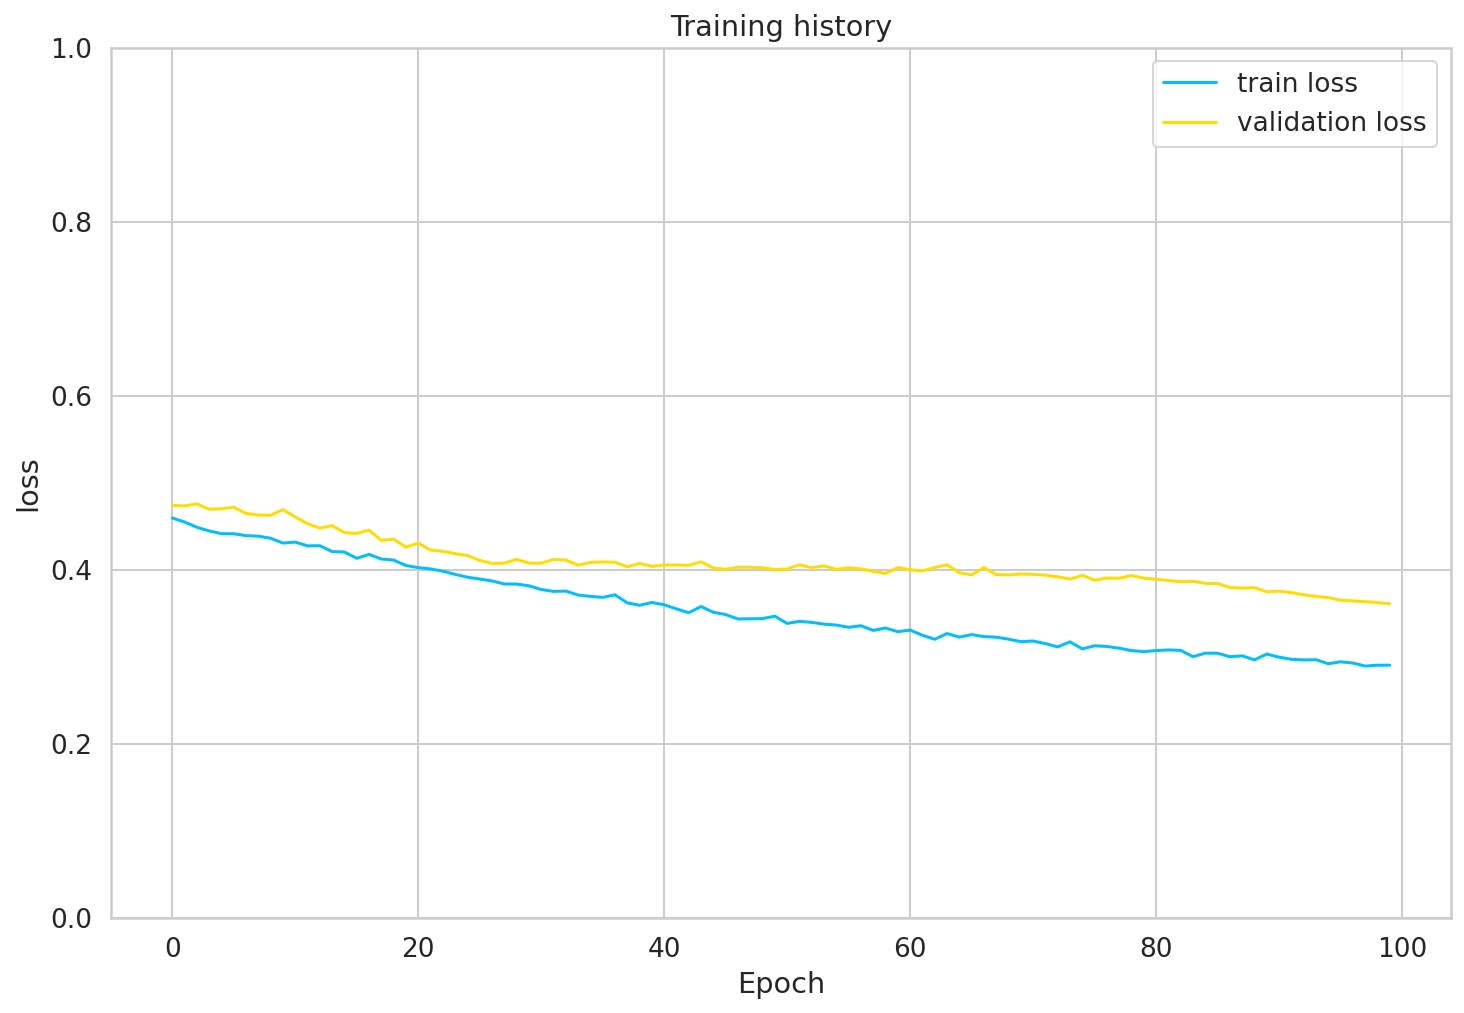

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Using 10% data as test set and testing the trained model for calculating accuracy

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test)
)

test_acc.item()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


0.8535879254341125

**Testing on Test set**

The test set has single text split into multiple text , so we find the predictions for same 

In [ ]:
articles=[]
preds=[]
with torch.no_grad():
    for d in test_data_loader:
        article=d["article_id"]
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        token_type_ids = d['token_type_ids'].to(device, dtype = torch.long)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
      
        loss = loss_fn(outputs, targets.type_as(outputs))
        outputs=outputs.sigmoid()
        outputs = np.where(outputs.cpu()>= 0.5,1,0)
        articles.append(int(article.cpu().numpy()[0]))
        preds.append(outputs[0].tolist())
test_results=pd.DataFrame({'articles':articles,'Predictions':preds})

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
test_results.sort_values('articles')

Now making the code to make a voting classifier. here the article paragraph is split into multiple lines so that the model could train within 4096 tokens

As you can see one article id has more than one entry. .so we will join create a voting ensemble model to get the score for each class


In [ ]:
import scipy
def moding(labels):
  return np.squeeze(scipy.stats.mode(labels.values[:,1:], axis=0)[0],axis=0)

,article_id,TEXT,LABEL
0,11547,Editorial Notes T he performance of the journa...,"[0, 0, 0, 0, 0, 0, 0, 1, 0]"
9,2869,New games new rules big data and the changing ...,"[0, 0, 0, 0, 0, 0, 0, 1, 0]"
87,12514,Information Technology and Organizational Cont...,"[0, 1, 0, 0, 0, 0, 0, 1, 0]"
134,6088,Factors affecting perceptions of CASE effectiv...,"[0, 1, 0, 0, 0, 0, 0, 0, 1]"


In [ ]:
test_results_2=pd.concat([test_results['articles'],pd.DataFrame(test_results['Predictions'].tolist(), index= test_results.index)],axis=1)
test_results_2=test_results_2.groupby('articles').apply(moding).reset_index().rename(columns={0:'Predictions'})
test_results_2=  pd.concat([test_results_2['articles'],pd.DataFrame(test_results_2['Predictions'].tolist(), index= test_results_2.index)],axis=1)

In [ ]:
test_results_2

Test set 

In [ ]:
test_2=test.drop(['TEXT'],1)
test_2.drop_duplicates(subset=['article_id'],inplace=True)
test_2=  pd.concat([test_2['article_id'],pd.DataFrame(test_2['LABEL'].tolist(), index= test_2.index)],axis=1)
test_2

In [ ]:
label_names=dataset.iloc[:,3:-1].columns.tolist()
label_names

In [ ]:
from sklearn.metrics import roc_curve, auc,accuracy_score,recall_score,precision_score
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
accuracy=dict()
precison=dict()
recall=dict()
for j in range(num_labels):
  i=label_names[j]
  fpr[i], tpr[i], _ = roc_curve(test_2.loc[:, j], test_results_2.loc[:, j])
  roc_auc[i] = auc(fpr[i], tpr[i])
  accuracy[i]=accuracy_score(test_2.loc[:, j], test_results_2.loc[:, j])
  precison[i]=precision_score(test_2.loc[:, j], test_results_2.loc[:, j])
  recall[i]=recall_score(test_2.loc[:, j], test_results_2.loc[:, j])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_2.iloc[:, 1:].values.ravel(), test_results_2.iloc[:, 1:].values.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
precison